Drag Models


In [11]:
import orekit
from orekit.pyhelpers import setup_orekit_curdir, datetime_to_absolutedate
import numpy as np
# orekit.pyhelpers.download_orekit_data_curdir()
vm = orekit.initVM()
setup_orekit_curdir("orekit-data.zip")

In [3]:
import requests
import os
def download_file_url(url, local_filename):
    from java.io import File
    #mianly used to download the  solfsmy and dtc files for JB2008
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return File(local_filename)

os.makedirs("external/jb08_inputs", exist_ok=True)
#make the blank file
open("external/jb08_inputs/SOLFSMY.TXT", 'a').close()
open("external/jb08_inputs/DTCFILE.TXT", 'a').close()

# Download SOLFSMY and DTCFILE files for JB2008 model
solfsmy_file = download_file_url("https://sol.spacenvironment.net/JB2008/indices/SOLFSMY.TXT", "external/jb08_inputs/SOLFSMY.TXT")
dtcfile_file = download_file_url("https://sol.spacenvironment.net/JB2008/indices/DTCFILE.TXT", "external/jb08_inputs/DTCFILE.TXT")

from org.orekit.data import DataSource
# Create DataSource instances
solfsmy_data_source = DataSource(solfsmy_file)
dtcfile_data_source = DataSource(dtcfile_file)


In [4]:
from org.orekit.models.earth import ReferenceEllipsoid
from org.orekit.bodies import CelestialBodyFactory
from orekit import JArray_double
from org.orekit.forces.drag import DragForce, IsotropicDrag
from org.orekit.models.earth.atmosphere.data import JB2008SpaceEnvironmentData
from org.orekit.models.earth.atmosphere import JB2008
from org.orekit.time import TimeScalesFactory   
from orekit.pyhelpers import datetime_to_absolutedate
from org.hipparchus.geometry.euclidean.threed import Vector3D
from org.orekit.orbits import CartesianOrbit, OrbitType
from org.orekit.utils import Constants, PVCoordinates, IERSConventions
from org.orekit.propagation.numerical import NumericalPropagator
from org.hipparchus.ode.nonstiff import DormandPrince853Integrator
from org.orekit.forces.gravity.potential import GravityFieldFactory
from org.orekit.forces.gravity import HolmesFeatherstoneAttractionModel
from org.orekit.frames import FramesFactory
from orekit import JArray_double
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [30]:
initial_sma = np.linalg.norm(np.array([-1620690.1530842409,2615729.21083149,6120829.369866818]))
print("Initial altitude: ", initial_sma/1000-6378.137)

Initial altitude:  472.64602471517355


In [31]:
# Step 3: Define Initial Conditions
# Define initial position (m) and velocity (m/s) in ECI frame
initial_position = [-1620690.1530842409,2615729.21083149,6120829.369866818]
initial_velocity = [-3872.165771597047,5607.204834079615,-3424.20599420816]

mass = 1000  # Mass of the spacecraft in kg

# Define start and end dates for propagation
start_date = datetime(2024, 1, 1, 0, 0, 0)  # Start date
end_date = start_date + timedelta(hours=3)  # Propagate for 3 hours

# Step 4: Create Initial Orbit and Propagator
# Convert dates to Orekit AbsoluteDate
initial_date = datetime_to_absolutedate(start_date)
frame = FramesFactory.getEME2000()

# Define the initial orbit
initial_orbit = CartesianOrbit(PVCoordinates(
        Vector3D(float(initial_position[0]), float(initial_position[1]), float(initial_position[2])),
        Vector3D(float(initial_velocity[0]), float(initial_velocity[1]), float(initial_velocity[2]))),frame,initial_date,Constants.WGS84_EARTH_MU)

# Set numerical integrator parameters
min_step = 0.001
max_step = 100.0
initial_step = 60.0
position_tolerance = 1.0  # Tolerance in meters
tolerances = NumericalPropagator.tolerances(position_tolerance, initial_orbit, OrbitType.CARTESIAN)
integrator = DormandPrince853Integrator(min_step, max_step, JArray_double.cast_(tolerances[0]), JArray_double.cast_(tolerances[1]))
integrator.setInitialStepSize(initial_step)

# Create numerical propagator
propagator_drag = NumericalPropagator(integrator)
propagator_no_drag = NumericalPropagator(integrator)
propagator_drag.setOrbitType(OrbitType.CARTESIAN)
propagator_no_drag.setOrbitType(OrbitType.CARTESIAN)

# Step 5: Configure Force Models
from org.orekit.propagation import SpacecraftState

# Add Earth's gravity field to the propagator
gravity_provider = GravityFieldFactory.getNormalizedProvider(12, 12)  # 12x12 gravity model
gravity_force = HolmesFeatherstoneAttractionModel(
    FramesFactory.getITRF(IERSConventions.IERS_2010, False), gravity_provider
)
#add gravity to both propagators
propagator_drag.addForceModel(gravity_force)
propagator_no_drag.addForceModel(gravity_force)

## Drag Model
wgs84Ellipsoid = ReferenceEllipsoid.getWgs84(FramesFactory.getITRF(IERSConventions.IERS_2010, False))
jb08_data = JB2008SpaceEnvironmentData(solfsmy_data_source,dtcfile_data_source)
utc = TimeScalesFactory.getUTC()
sun = CelestialBodyFactory.getSun()
atmosphere = JB2008(jb08_data, sun, wgs84Ellipsoid, utc)
cross_section = 20.0  # in m^2
cd = 2.2  # drag coefficient
drag_sensitive = IsotropicDrag(float(cross_section), float(cd))
dragForce = DragForce(atmosphere, drag_sensitive)

#only add drag to the drag propagator
propagator_drag.addForceModel(dragForce)

# Create the initial spacecraft state with orbit and mass
initial_state = SpacecraftState(initial_orbit, float(mass))

# Set the initial state for the propagators
propagator_drag.setInitialState(initial_state)
propagator_no_drag.setInitialState(initial_state)

# Step 6: Propagate the Orbit
step_size = 60.0  # Output step size in seconds
current_date = initial_date
results = []

while current_date.compareTo(datetime_to_absolutedate(end_date)) <= 0:
    state_drag = propagator_drag.propagate(current_date)
    state_no_drag = propagator_no_drag.propagate(current_date)
    position_drag = state_drag.getPVCoordinates().getPosition()
    position_no_drag = state_no_drag.getPVCoordinates().getPosition()
    velocity_drag = state_drag.getPVCoordinates().getVelocity()
    velocity_no_drag = state_no_drag.getPVCoordinates().getVelocity()
    results.append({
        "UTC": current_date.toString(),
        "x_drag": position_drag.getX(), "y_drag": position_drag.getY(), "z_drag": position_drag.getZ(),
        "vx_drag": position_drag.getX(), "vy_drag": position_drag.getY(), "vz_drag": position_drag.getZ(),
        "x_no_drag": position_no_drag.getX(), "y_no_drag": position_no_drag.getY(), "z_no_drag": position_no_drag.getZ(),
        "vx_no_drag": position_no_drag.getX(), "vy_no_drag": position_no_drag.getY(), "vz_no_drag": position_no_drag.getZ(),
    })
    current_date = current_date.shiftedBy(step_size)  # Advance by step size

# Convert results to a DataFrame
df = pd.DataFrame(results)

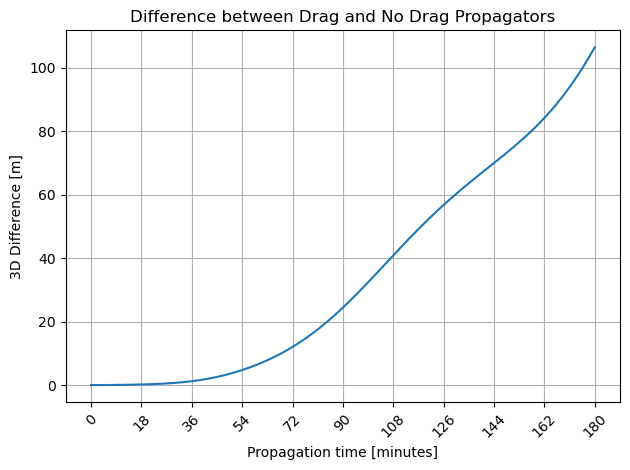

In [32]:
#at each time step plot the euclidean distance between the drag and no drag propagatiors
df['3D_diff'] = ((df['x_drag'] - df['x_no_drag'])**2 + (df['y_drag'] - df['y_no_drag'])**2 + (df['z_drag'] - df['z_no_drag'])**2)**0.5

#make a new columns called minutes that is the time in minutes from the start
df['minutes'] = (pd.to_datetime(df['UTC']) - pd.to_datetime(df['UTC'][0])).dt.total_seconds() / 60

# Plot the 3D difference between drag and no drag propagators
plt.figure()
plt.plot(df['minutes'], df['3D_diff'])
plt.xlabel('Propagation time [minutes]')
#only plot 10 equally space xticks
plt.xticks(df['minutes'][::len(df['UTC'])//10], rotation=45)
plt.ylabel('3D Difference [m]')
plt.title('Difference between Drag and No Drag Propagators')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [41]:
from org.orekit.forces import ForceModel
def extract_acceleration(state_vector_data, TLE_epochDate, SATELLITE_MASS, forceModel, rtn=False):
    """
    Extracts acceleration data using a specified force model and optionally computes RTN components.

    :param state_vector_data: Single state vector or Dictionary containing state vectors and corresponding times.
    :param TLE_epochDate: The initial epoch date for TLE.
    :param SATELLITE_MASS: The mass of the satellite.
    :param forceModel: The instance of the force model to be used.
    :param rtn: Boolean flag to compute RTN components.
    :return: List of acceleration vectors and optionally RTN components.
    """
    # Function to compute unit vector
    def unit_vector(vector):
        norm = vector.getNorm()
        if norm == 0:
            raise ValueError("Cannot normalize zero vector")
        return Vector3D(vector.getX() / norm, vector.getY() / norm, vector.getZ() / norm)

    # Check if state_vector_data is a dictionary or a single state vector
    if not isinstance(state_vector_data, dict):
        # Assume state_vector_data is a single state vector
        state_vector_data = {'single_state': ([0], [state_vector_data])}

    # Extract states and times for the ephemeris
    states_and_times = state_vector_data[next(iter(state_vector_data))]
    times, states = states_and_times

    # Extract accelerations and RTN components
    accelerations = []
    rtn_components = [] if rtn else None
    for i, pv in enumerate(states):
        duration = times[i]  # Duration in seconds
        if duration == 0:
            current_date = TLE_epochDate
        else:
            current_date = TLE_epochDate.shiftedBy(duration)

        position = Vector3D(float(pv[0]), float(pv[1]), float(pv[2]))

        velocity = Vector3D(float(pv[3]), float(pv[4]), float(pv[5]))
        pvCoordinates = PVCoordinates(position, velocity)

        orbit = CartesianOrbit(pvCoordinates, FramesFactory.getEME2000(), current_date, Constants.WGS84_EARTH_MU)
        state = SpacecraftState(orbit, float(SATELLITE_MASS))

        parameters = ForceModel.cast_(forceModel).getParameters()
        acc = forceModel.acceleration(state, parameters)
        accelerations.append(acc)

        if rtn:
            # Compute RTN components
            print(f"position: {position}")
            radial_unit_vector = unit_vector(position)
            normal_unit_vector = unit_vector(Vector3D.crossProduct(position, velocity))
            transverse_unit_vector = unit_vector(Vector3D.crossProduct(normal_unit_vector, radial_unit_vector))

            radial_component = Vector3D.dotProduct(acc, radial_unit_vector)
            transverse_component = Vector3D.dotProduct(acc, transverse_unit_vector)
            normal_component = Vector3D.dotProduct(acc, normal_unit_vector)
            rtns = [radial_component, transverse_component, normal_component]
            rtn_components.append(rtns)

    return (accelerations, rtn_components) if rtn else accelerations

In [43]:
#make a list called state vectors that contains the positions and velocities of the satellite at each time step
state_vectors = []
for i in range(len(df)):
    state_vectors.append([df['x_drag'][i]*1000, df['y_drag'][i]*1000, df['z_drag'][i]*1000, df['vx_drag'][i]*1000, df['vy_drag'][i]*1000, df['vz_drag'][i]*1000])

#make a list called epochs that is the UTC time stamps that we have converted to absolute dates using datetime_to_absolutedate
epochs = []
for i in range(len(df)):
    #conver the UTC to datetime object first and then to absolute date
    epochs.append(datetime_to_absolutedate(datetime.strptime(df['UTC'][i], '%Y-%m-%dT%H:%M:%S.%fZ')))
    

#now extract the acceleration for each state vector at each time step
atmospheric_drag_accs = []
for state_vector in state_vectors:
    epoch_date = epochs[state_vectors.index(state_vector)]
    atmospheric_drag_acc = extract_acceleration(state_vector, epoch_date, mass, dragForce, rtn=False)
    atmospheric_drag_acc = np.array([atmospheric_drag_acc[0].getX(), atmospheric_drag_acc[0].getY(), atmospheric_drag_acc[0].getZ()])
    atmospheric_drag_accs.append(atmospheric_drag_acc)

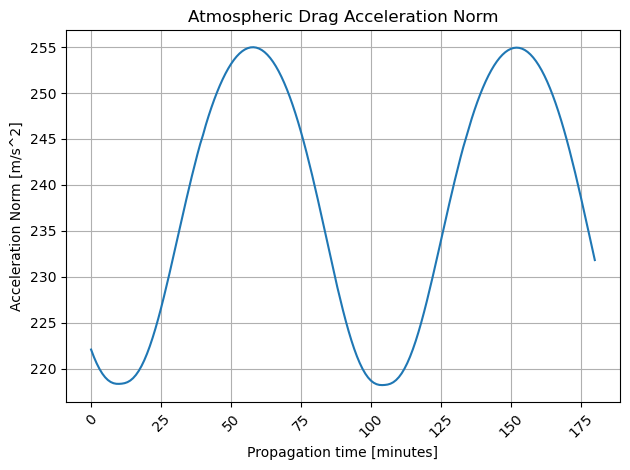

In [44]:
#plot the norm of the acceleration over time
acc_norms = np.linalg.norm(atmospheric_drag_accs, axis=1)
plt.figure()
plt.plot(df['minutes'], acc_norms)
plt.xlabel('Propagation time [minutes]')
plt.ylabel('Acceleration Norm [m/s^2]')
plt.title('Atmospheric Drag Acceleration Norm')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()
